In [0]:
#import the modules
from __future__ import print_function
import tensorflow as tf
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools


from torch import nn, optim
from PIL import Image
from numpy import array

In [0]:
!pip install syft
import syft as sy
hook = sy.TorchHook(th)


W0819 08:19:21.879760 140033827145600 hook.py:98] Torch was already hooked... skipping hooking process


In [0]:
#check if cuda is available on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 380  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/rsz_p3.jpg")
content_img = image_loader("/content/albert.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

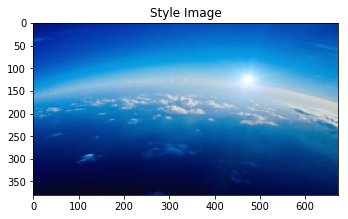

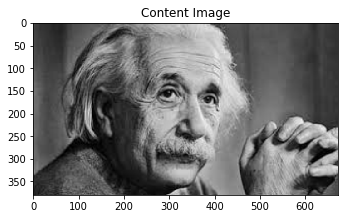

In [0]:
#a function that displays an image by reconverting a copy of it to PIL format and displaying the copy using plt.imshow. We will try displaying the content and style images to ensure they were imported correctly.

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.subplot(1,2,2)
imshow(style_img, title='Style Image')

plt.subplot(1,2,2)
imshow(content_img, title='Content Image')

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [0]:
#Using transfer learning
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

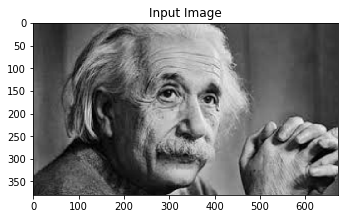

In [0]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.subplot(1,2,2)
imshow(input_img, title='Input Image')

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/syft/frameworks/torch/hook/hook.py:779: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 22841.693359 Content Loss: 3.087856

run [100]:
Style Loss : 18028.025391 Content Loss: 4.387057

run [150]:
Style Loss : 9887.573242 Content Loss: 5.342309

run [200]:
Style Loss : 3579.949219 Content Loss: 5.969664

run [250]:
Style Loss : 790.581482 Content Loss: 6.325731

run [300]:
Style Loss : 239.550827 Content Loss: 6.543705



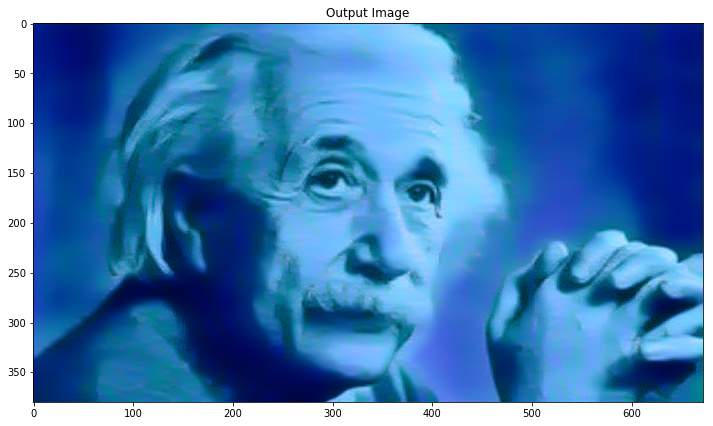

In [0]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

fig=plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
fig.savefig('out.jpg')
plt.show()


In [0]:
import cv2
img = cv2.imread("out.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print (type(img))


<class 'numpy.ndarray'>


In [0]:
img


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

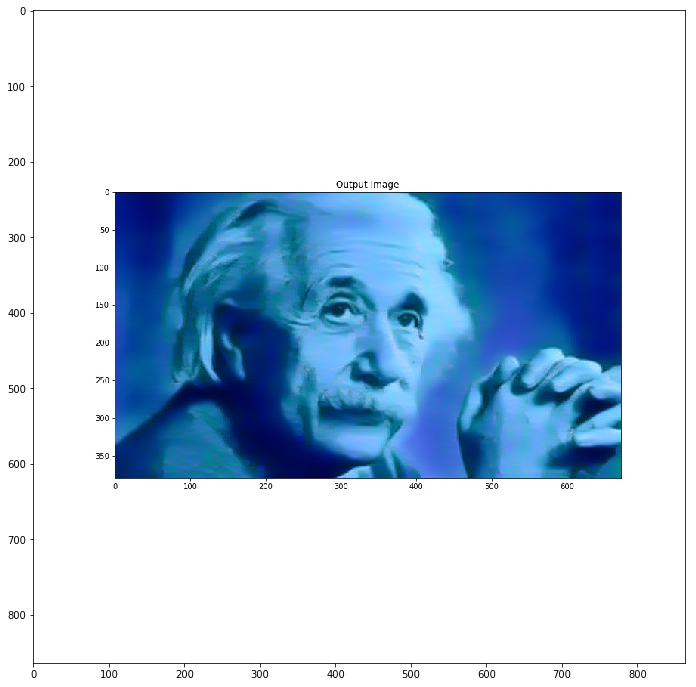

In [0]:
plt.imshow(img)
  

In [0]:
x=th.tensor(img)

In [0]:
x

tensor([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

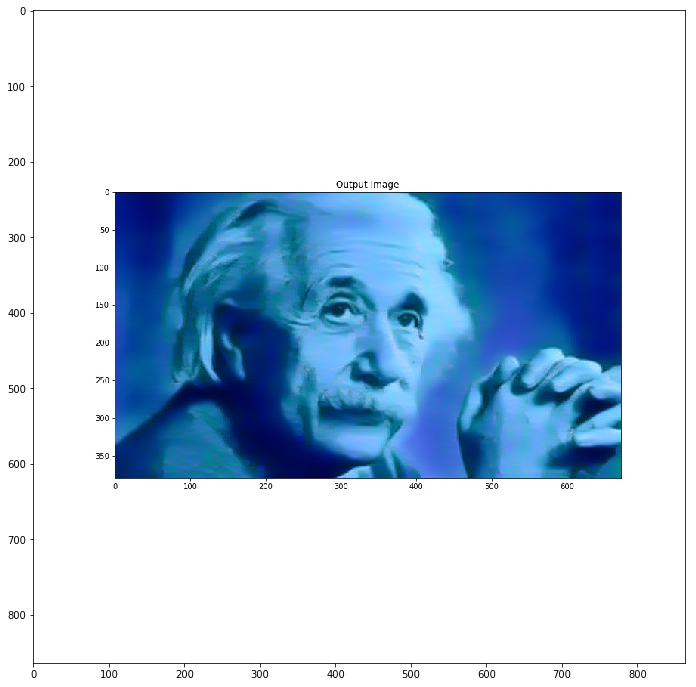

In [0]:
plt.imshow(x)
plt.savefig("hy.jpg")

In [0]:
x.id

1530553657

# Using Encryption to send style image

In [0]:
import random
import numpy as np

BASE = 10

PRECISION_INTEGRAL = 8
PRECISION_FRACTIONAL = 8
Q = 293973345475167247070445277780365744413

PRECISION = PRECISION_INTEGRAL + PRECISION_FRACTIONAL

assert(Q > BASE**PRECISION)

def encode(rational):
    upscaled = int(rational * BASE**PRECISION_FRACTIONAL)
    field_element = upscaled % Q
    return field_element

def decode(field_element):
    upscaled = field_element if field_element <= Q/2 else field_element - Q
    rational = upscaled / BASE**PRECISION_FRACTIONAL
    return rational

def encrypt(secret):
    first  = random.randrange(Q)
    second = random.randrange(Q)
    third  = (secret - first - second) % Q
    return [first, second, third]

def decrypt(sharing):
    return sum(sharing) % Q



In [0]:
user_1 = sy.VirtualWorker(hook, id="user_1")
user_2 = sy.VirtualWorker(hook, id="user_2")

In [0]:
x=th.tensor(img).send(user_1)

In [0]:
x.id

9909860816

In [0]:

location_id = encrypt(encode(x.id))


In [0]:
location_id

[159495092267061610386987644777071057391,
 25811463450411445969281249222732784103,
 108666789757694190715167369862161902919]

In [0]:
true_loc=int((decode(decrypt(location_id))))

In [0]:
true_loc

9909860816

In [0]:
#Checking if everything went well
if(x.id==true_loc):
  x=x.send(user_2)
  print(x.location,"picture sent from sender to receiver")
else:
  x.get() # we will not send the data to receiver because it may be dangerous
  print("Something is fishy")
  

<VirtualWorker id:user_2 #objects:1> picture sent from sender to receiver


In [0]:
user_2._objects

{9909860816: (Wrapper)>[PointerTensor | user_2:9909860816 -> user_1:65030544876]}

In [0]:
user_1.clear_objects()

<VirtualWorker id:user_1 #objects:0>

In [0]:
user_2.clear_objects()

<VirtualWorker id:user_2 #objects:0>

# Secret Sharing using  PySyft





In [0]:
# create a couple workers

user_1 = sy.VirtualWorker(hook, id="user_1")
user_2 = sy.VirtualWorker(hook, id="user_2")
secure_worker = sy.VirtualWorker(hook, id="secure_worker")

user_1.add_workers([user_2, secure_worker])
user_2.add_workers([user_1, secure_worker])
secure_worker.add_workers([user_2,user_2])




W0819 08:46:42.617027 140033827145600 base.py:646] Worker user_2 already exists. Replacing old worker which could cause                     unexpected behavior
W0819 08:46:42.620985 140033827145600 base.py:646] Worker secure_worker already exists. Replacing old worker which could cause                     unexpected behavior
W0819 08:46:42.622493 140033827145600 base.py:646] Worker user_1 already exists. Replacing old worker which could cause                     unexpected behavior
W0819 08:46:42.624546 140033827145600 base.py:646] Worker secure_worker already exists. Replacing old worker which could cause                     unexpected behavior
W0819 08:46:42.627084 140033827145600 base.py:646] Worker user_2 already exists. Replacing old worker which could cause                     unexpected behavior
W0819 08:46:42.628335 140033827145600 base.py:646] Worker user_2 already exists. Replacing old worker which could cause                     unexpected behavior


<VirtualWorker id:secure_worker #objects:0>

In [0]:
x=th.tensor(img)
x=x.share(user_1, user_2, crypto_provider=secure_worker)

In [0]:
x

(Wrapper)>[AdditiveSharingTensor]
	-> [PointerTensor | me:24637293757 -> user_1:6785756652]
	-> [PointerTensor | me:41574158229 -> user_2:68236538210]
	*crypto provider: secure_worker*

In [0]:
z=x.get()


In [0]:
z

tensor([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [0]:
user_1._objects

{}

In [0]:
user_2._objects


{}

In [0]:
#clearing data
user_1.clear_objects()


<VirtualWorker id:user_1 #objects:0>

In [0]:
user_2.clear_objects()

<VirtualWorker id:user_2 #objects:0>

# Remote Airthmatic and check truthness

In [0]:
#we are sending style image to both sender and receiver initially
x = th.tensor(img).send(user_1)

In [0]:
x

(Wrapper)>[PointerTensor | me:37513680105 -> user_1:84148224455]

In [0]:

x = x.send(user_2)

In [0]:
user_1._objects



{84148224455: tensor([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         ...,
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 2

In [0]:
# receiver have acknowledge of x point to how many of them 
user_2._objects

{37513680105: (Wrapper)>[PointerTensor | user_2:37513680105 -> user_1:84148224455]}

In [0]:

# a hacker jon comes to same network and he got the data
jon = sy.VirtualWorker(hook, id="jon")
x=th.tensor(img).send(jon)


jon._objects


{98894421766: tensor([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         ...,
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 2

In [0]:
if(bool(user_2._objects)==False):
  print("data is compromised")
else:
  print("data is safe")
  

data is compromised


In [0]:
x.get()

tensor([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [0]:
user_1._objects


{}

In [0]:
user_2._objects

{}

In [0]:
x = th.tensor(img).send(user_1).send(user_2)

In [0]:
#suppose we don't want to give the message to receiver somehow we found a glitch in message so we want to retrieve msg from receiver
x.get()

(Wrapper)>[PointerTensor | me:12134663147 -> user_1:11217893110]

In [0]:
user_1._objects

{11217893110: tensor([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         ...,
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 2

In [0]:
user_2._objects

{}

In [0]:
user_1.clear_objects()

<VirtualWorker id:user_1 #objects:0>